# Training The NN : Fasion Classification

In [3]:
from __future__ import absolute_import, division, print_function, unicode_literals

# tensorflow와 tf.keras 불러오기~
import tensorflow as tf
from tensorflow import keras

# helper library 임포트
import numpy as np
import matplotlib.pyplot as plt

print(tf.__version__)

1.13.1


# Fasion 데이터셋 임포트
아래는 5개의 category와 
1500개의 컬러 이미지로 구성된 fasion dataset입니다. 
이미지의 해상도는 128x128 pixel.
<br>
load_data() 함수를 호출하면 네 개의 넘파이(NumPy) 배열이 반환됩니다:
- train_X와 train_y 배열은 모델 학습에 사용되는 *training set* 입니다.
- test_X와 test_y 배열은 모델 테스트에 사용되는 *test set* 입니다.<br>
<br>이미지는 28x28 크기의 넘파이 배열이고 픽셀 값은 0과 255 사이입니다. 레이블(label)은 0에서 9까지의 정수 배열입니다. 이 값은 이미지에 있는 옷의 클래스(class)를 나타냅니다:<br>
<br>
0	    white<br>
1	    pink<br>
2	    green<br>
3	    blue<br>
4	    orange<br>


5	    Sandal<br>
6	    Shirt<br>
7	    Sneaker<br>
8	    Bag<br>
9	    Ankle boot

In [13]:
# Dataset 전처리
import os
import cv2
#src = "C:/Users/chief/FittingroomAnywhere/GAN/white2green/trainB/" # green
dst = "C:/Users/chief/Desktop/data/train/0/" # white
#src = "C:/Users/chief/Desktop/orange"
#src = "C:/Users/chief/Desktop/blue"
#src = "C:/Users/chief/Desktop/pink"
src = "C:/Users/chief/Desktop/white"
#src = "C:/Users/chief/Desktop/"

if not os.path.exists(dst):
    os.mkdir(dst)

filenum = 0
for each in os.listdir(src):
    filename = str(filenum) + '.jpg'
    img = cv2.imread(os.path.join(src,each))
    if img is not None and img.size != 0:
        img = cv2.resize(img,(128,128))
        cv2.imwrite(os.path.join(dst,filename), img)
    filenum += 1

In [14]:
# Augmentation
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

datagen = ImageDataGenerator(
        rotation_range=20,
        width_shift_range=0.05,
        height_shift_range=0.05,
        shear_range=0.1,
        horizontal_flip=True,
        fill_mode='constant', cval=255)

for imgfile in os.listdir(dst):
    img = load_img(os.path.join(dst,imgfile))  # PIL 이미지
    x = img_to_array(img)  # (3, 128, 128) 크기의 NumPy 배열
    x = x.reshape((1,) + x.shape)  # (1, 3, 120, 128) 크기의 NumPy 배열

    # 아래 .flow() 함수는 임의 변환된 이미지를 배치 단위로 생성해서
    # 지정된 `dst/` 폴더에 저장합니다.
    i = 0
    for batch in datagen.flow(x, batch_size=1,
                              save_to_dir=dst, save_prefix='0', save_format='jpg'):
        i += 1
        if i > 3:
            break  # 이미지 3장을 생성하고 마칩니다

In [3]:
# 패션 MNIST 데이터셋은 텐서플로에서 바로 임포트하여 적재할 수 있습니다:
fasion_mnist = keras.datasets.fashion_mnist
(train_X, train_y), (test_X, test_y) = fasion_mnist.load_data()

# 데이터셋에 클래스 이름이 들어있지 않기 때문에(0~9의 숫자로 레이블링됨)
# 이미지를 출력할 때 사용하기 위해 별도의 변수를 만들어 저장합니다:
class_names = ['white', 'stripe', 'green', 'blue', 'orange']

4423680/4422102 [==============================] - 3s 1us/step


# 데이터 탐색
모델을 훈련하기 전에 데이터셋 구조를 살펴보죠. 다음 코드는 training set에 60,000개, test set에 10,000개의 이미지가 있다는 것을 보여줍니다. 각 이미지는 28x28 픽셀로 표현됩니다:

In [5]:
train_X.shape

(60000, 28, 28)

In [6]:
test_X.shape

(10000, 28, 28)

In [9]:
# label은 0부터 9까지 총 10개
set(train_y)

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9}

# 데이터 전처리
네트워크를 훈련하기 전에 데이터 전처리가 필요합니다. training set에 있는 첫 번째 이미지를 보면 픽셀값의 범위가 0~255 사이라는 것을 알 수 있습니다.

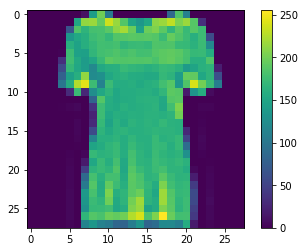

In [16]:
plt.figure()
plt.imshow(train_X[10])
plt.colorbar()
plt.grid(False)
plt.show()

신경망 모델에 주입하기 전에 픽셀값의 범위를 0~1 사이로 조정합니다. training set와 test set 둘 다 255로 나누어 normalize 합니다.

In [17]:
train_X = train_X / 255.0
test_X = test_X / 255.0

train set에서 처음 25개 이미지와 클래스 이름을 출력해보겠습니다. 데이터 포맷이 올바른지 확인하고 네트워크 구성과 훈련할 준비를 마칩니다.

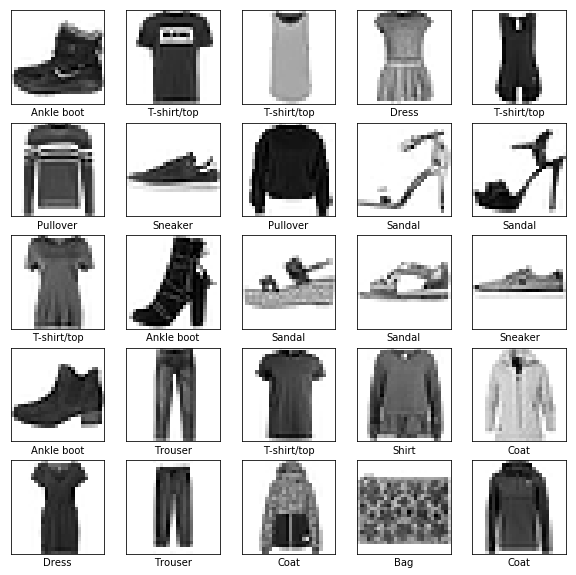

In [24]:
plt.figure(figsize = (10,10))
for i in range(25):
    plt.subplot(5,5, i+1) #5x5 subplot에서 i+1번째 subplot을 의미함
    plt.xticks([]) #x축에 눈금을 없애는 역할
    plt.yticks([]) #x축에 눈금을 없애는 역할
    plt.grid(False)
    plt.imshow(train_X[i], cmap = plt.cm.binary) #cmap = plt.cm.binary 는 흑백으로 보이게
    plt.xlabel(class_names[train_y[i]])
plt.show()

# 모델 구성
신경망 모델을 만들기 위해 
모델의 layer를 구성한 다음 모델을 compile합니다.<br>

## Layer 설정
신경망의 기본 구성 요소는 layer입니다. 레이어는 주입된 데이터에서 아웃풋을 출력합니다.<br>
대부분의 딥러닝들은 간단한 레이어를 연결하여 구성됩니다. `tf.keras.layers.Dense`와 같은 레이어의 parameter들은 훈련하는 동안 학습됩니다.

In [25]:
model = keras.Sequential([
    keras.layers.Flatten(input_shape=(28,28)),
    keras.layers.Dense(128, activation=tf.nn.relu),
    keras.layers.Dense(10, activation=tf.nn.softmax)
])

위 네트워크의 첫 번째 층인 `tf.keras.Flatten`은 2차원 배열(28x28픽셀)의 이미지 포맷을 28x28 = 784 픽셀의 1차원 배열로 변환합니다. 이 층은 이미지에 있는 픽셀의 행을 펼쳐서 일렬로 늘립니다. 이 층에는 학습되는 가중치가 없고 **데이터를 변환하기만** 합니다.

픽셀을 펼친 후에는 두 개의 `tf.keras.layers.Dense` 층이 연속되어 연결됩니다. 이 층을 Densely-connected 또는 Fully-connected 층이라고 부릅니다. 첫 번째 `Dense` 층은 128개의 노드(뉴런)를 가집니다. 두 번째(마지막) 층은 10개 노드의 Softmax 층입니다. 이 층은 10개의 확률값을 반환하고 반환된 값의 전체 합은 1입니다. 소프트맥스는 인풋(현재 이미지)이 10개의 클래스에 속할 확률을 각각 출력합니다.

## 모델 컴파일
모델을 훈련하기 전에 필요한 몇 가지 설정이 *컴파일 단계* 에서 추가됩니다.<br>

- 손실 함수(Loss function): 훈련하는 동안 모델의 오차를 측정합니다. 모델의 학습이 올바른 방향으로 향하도록 이 함수를 최소화해야 합니다.
- 옵티마이저(Optimizer): 데이터와 손실함수를 바탕으로 모델의 업데이트 방법을 결정합니다.
- 지표(Metrics): 훈련 단계와 테스트 단계를 평가하기 위해 사용합니다. 다음 예에서는 올바르게 분류된 이미지의 비율인 *정확도(Accuracy)*를 사용합니다

In [27]:
model.compile(optimizer = 'adam',
             loss = 'sparse_categorical_crossentropy',
             metrics = ['accuracy'])

## 모델 훈련
신경망 모델을 훈련하는 단계는 다음과 같습니다:
1. 훈련 데이터를 모델에 주입합니다. 여기서는 train_X 와 train_y 입니다.
2. 모델이 이미지와 레이블을 매핑하는 방법을 배웁니다.
3. test set에 대한 모델의 예측을 만듭니다. test_X가 test_y의 레이블과 맞는지 확인합니다.

훈련을 시작하기 위해 model.fit을 호출하면 모델이 훈련 데이터를 8 epoch만큼 학습합니다. epoch 지날수록 트레이닝 셋에 대한 accuracy 증가합니다.

In [29]:
model.fit(train_X, train_y, epochs = 8)

Train on 60000 samples
Epoch 1/8
60000/60000 [==============================] - 7s 116us/sample - loss: 0.2800 - accuracy: 0.8980
Epoch 2/8
60000/60000 [==============================] - 7s 121us/sample - loss: 0.2686 - accuracy: 0.9004
Epoch 3/8
60000/60000 [==============================] - 8s 136us/sample - loss: 0.2566 - accuracy: 0.9048
Epoch 4/8
60000/60000 [==============================] - 8s 134us/sample - loss: 0.2481 - accuracy: 0.9080
Epoch 5/8
60000/60000 [==============================] - 9s 149us/sample - loss: 0.2371 - accuracy: 0.9119
Epoch 6/8
60000/60000 [==============================] - 7s 121us/sample - loss: 0.2282 - accuracy: 0.9153
Epoch 7/8
60000/60000 [==============================] - 8s 136us/sample - loss: 0.2214 - accuracy: 0.9182
Epoch 8/8
60000/60000 [==============================] - 8s 136us/sample - loss: 0.2165 - accuracy: 0.9186


## 모델 성능 평가
테스트 셋에 대한 모델의 성능을 확인합니다. 성능의 지표로 설정한 정확도(Accuracy)를 확인합니다.

In [30]:
test_loss, test_acc = model.evaluate(test_X, test_y)
print('test accuracy : ', test_acc)

10000/10000 [==============================] - 1s 145us/sample - loss: 0.3492 - accuracy: 0.8793
test accuracy :  0.8793


## Prediction 예측하기
훈련된 모델을 사용해 이미지에 대한 예측을 할 수 있습니다.

In [31]:
predictions = model.predict(test_X)

In [36]:
print(predictions[0])
print([round(p, 4) for p in predictions[0]])

[1.41607103e-07 5.08480424e-10 1.20692825e-08 2.22955213e-11
 4.32984990e-08 1.14171696e-03 2.05671967e-07 6.49873465e-02
 1.29266780e-07 9.33870316e-01]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0011, 0.0, 0.065, 0.0, 0.9339]


위 출력값은 test_X의 0번째 이미지에 대한 10개 클래스의 신뢰도(confidence)를 나타냅니다. 가장 높은 신뢰도를 가진 레이블을 출력해보겠습니다.

In [37]:
print(np.argmax(predictions[0]))

9


모델은 위 `test_X[0]` 이미지가 앵클 부츠라고 가장 확신하고 있습니다. 93.39% 만큼 확신하고 있네요. 이 값이 맞는지 실제 레이블인 `test_y[0]`을 확인해보겠습니다.

In [38]:
test_y[0]

9

In [39]:
# 10 개 이미지의 신뢰도를 그래프로 표현
def plot_image(i, predict_arr, true_label, img):
    predict_arr, true_label, img = predict_arr[i], true_label[i], img[i]
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    
    plt.imshow(img, cmap = plt.cm.binary)
    
    predicted_label = np.argmax(predict_arr)
    if predicted_label == true_label:
        color = 'blue'
    else:
        color = 'red'
        
    plt.xlabel("{} {:2.0f}% ({})".format(class_names[predicted_label],
                                          100*np.max(predict_arr),
                                          class_names[true_label]), color=color)

def plot_value_array(i, predict_arr, true_label):
    predict_arr, true_label = predict_arr[i], true_label[i]
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    thisplot = plt.bar(range(10), predict_arr, color = "#777777" )
    plt.ylim([0,1])
    predicted_label = np.argmax(predict_arr)
    
    thisplot[predicted_label].set_color('red')
    thisplot[true_label].set_color('blue')

몇 개의 이미지의 예측을 출력해 보죠. 올바르게 예측된 레이블은 파란색이고 잘못 예측된 레이블은 빨강색입니다. 숫자는 예측 레이블의 신뢰도 퍼센트(100점 만점)입니다. 신뢰도 점수가 높을 때도 잘못 예측할 수 있습니다.

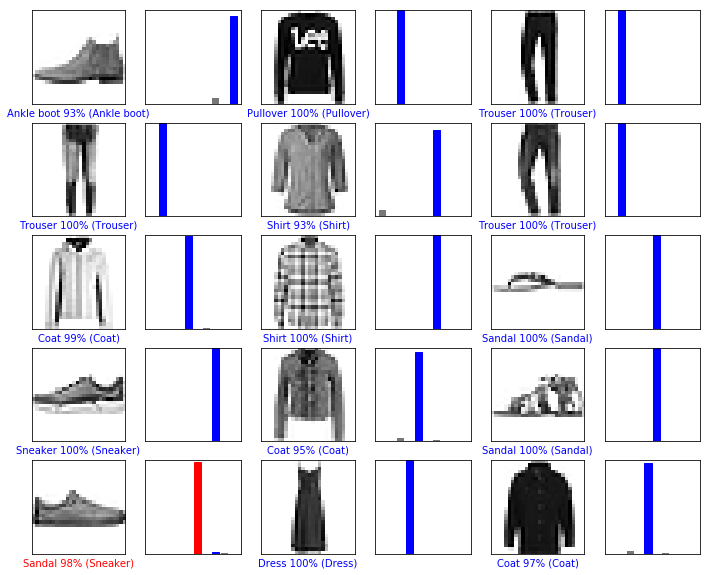

In [44]:
num_rows = 5
num_cols = 3
num_images = num_rows * num_cols

plt.figure(figsize = (2*2*num_cols, 2*num_rows))
for i in range(num_images): #15개
    plt.subplot(num_rows, 2*num_cols, 2*i+1)
    plot_image(i, predictions, test_y, test_X)
    plt.subplot(num_rows, 2*num_cols, 2*i+2)
    plot_value_array(i, predictions, test_y)
plt.show()

### 이미지 하나에 대한 예측

In [50]:
img = (np.expand_dims(test_X[100], 0))
pred = model.predict(img)
print(pred[0])

[8.4979534e-03 1.2571641e-05 2.4476298e-05 9.8738134e-01 2.6153095e-05
 4.4935604e-08 4.0556802e-03 4.9012454e-11 1.8948039e-06 2.0285341e-08]


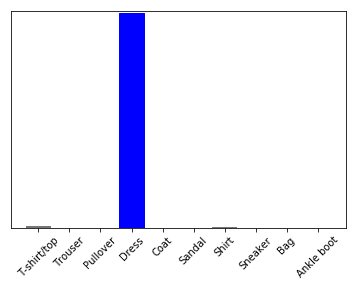

In [55]:
plot_value_array(0, pred, [test_y[100]])
plt.xticks(range(10), class_names, rotation = 45)
plt.show()

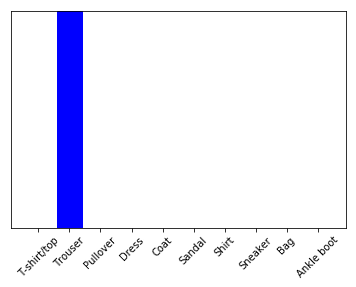

In [59]:
pred = model.predict((np.expand_dims(test_X[5],0)))
plot_value_array(0, pred, [test_y[5]])
plt.xticks(range(10), class_names, rotation = 45)
plt.show()

# 모델 저장

In [60]:
# Save model with json format
model_json = model.to_json()
with open("CNN_fashion_mnist_model.json", "w") as json_file:
    json_file.write(model_json)

# Save weight with h5 format
model.save_weights("CNN_fashion_mnist_model.h5")
print("Saved model to disk")

Saved model to disk


# 모델 불러오기
TF 2.0을 썼더니 `AttributeError: module 'tensorflow' has no attribute 'placeholder'` 에러가 떠서, https://www.tensorflow.org/versions/r2.0/api_docs/python/tf/keras/models/model_from_json 링크 내용을 참조해 아래와 같이 `from tensorflow.compat.v2.keras.models import model_from_json` 으로 import 했습니다.

In [67]:
from tensorflow.compat.v2.keras.models import model_from_json

# model.json 파일 열기
json_file = open("CNN_fashion_mnist_model.json", "r") 
loaded_model_json = json_file.read() 
json_file.close() 

# json파일로부터 model 로드하기
loaded_model = model_from_json(loaded_model_json)

# 로드한 model에 weight 로드하기
loaded_model.load_weights("CNN_fashion_mnist_model.h5")
print("Loaded model from disk")

Loaded model from disk


In [76]:
# 모델 컴파일
loaded_model.compile(optimizer = 'adam',
             loss = 'sparse_categorical_crossentropy',
             metrics = ['accuracy'])

# 모델 evaluation
test_loss, test_acc = loaded_model.evaluate(test_X, test_y)
print("Accuracy : %.2f%%" % (test_acc*100))

10000/10000 [==============================] - 1s 64us/sample - loss: 0.3501 - acc: 0.8793
Accuracy : 87.93%
